## Dual Doppler lobe plotter

DD lobe plotter. Needs py-ART Grid file since DD lobes are calculated in radar relative coordinates.

Based on code created by Scott Collis, Johnathan Helmus, Zachary Sherman, and myself

In [6]:
import pyart
import gzip
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy import ndimage
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import glob
import re
from copy import deepcopy
from IPython.display import Image, display
import math
%matplotlib inline
import pyproj
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



This looks for all of the available timeperiods in the data_path directory and pulls out
the file names that match the given time periods above.

In [20]:
def dms_to_decimal(degrees, minutes, seconds):
    if(degrees > 0):
        return degrees+minutes/60+seconds/3600
    else:
        return degrees-minutes/60-seconds/3600

def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

# Gets beam crossing angle over 2D grid centered over Radar 1. 
# grid_x, grid_y are cartesian coordinates from pyproj.Proj (or basemap)
def get_bca(rad1_lon, rad1_lat, 
            rad2_lon, rad2_lat,
            grid_lon, grid_lat):
    # Beam crossing angle needs cartesian coordinates
    p = ccrs.PlateCarree()
    p = p.as_geocentric()
    rad1 = p.transform_points(ccrs.PlateCarree().as_geodetic(),
                              np.array(rad1_lon), 
                              np.array(rad1_lat))
    rad2 = p.transform_points(ccrs.PlateCarree().as_geodetic(),
                              np.array(rad2_lon), 
                              np.array(rad2_lat))
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)
    grid = p.transform_points(ccrs.PlateCarree().as_geodetic(),
                              grid_lon,
                              grid_lat,
                              np.zeros(grid_lon.shape))
    # Create grid with Radar 1 in center
    x = grid[:,:,0]-rad1[0,0]
    y = grid[:,:,1]-rad1[0,1]
    rad2 = rad2 - rad1
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-rad2[0,0],2)+pow(y-rad2[0,1],2))
    c = np.sqrt(rad2[0,0]*rad2[0,0]+rad2[0,1]*rad2[0,1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-rad2[0,1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

def scale_bar(ax, length, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    """
    #Projection in metres, need to change this to suit your own figure
    utm = ccrs.UTM(14)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    #Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * 500, sbcx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbcx, sbcy, str(length) + ' km', transform=utm,
            horizontalalignment='center', verticalalignment='bottom')

## Grid plotting code

This code creates plots from all of the Grids developed by multidop

This loads the Grid files and creates the animation

In [35]:
def plot_dd_lobes(radar1_loc, radar2_loc, radar1_name, radar2_name):
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Amf locations
    i5 = [dms_to_decimal(-97, 35, 37.68), dms_to_decimal(36, 29, 29.4)]
    i4 = [dms_to_decimal(-97, 21, 49.32), dms_to_decimal(36, 34, 44.4)]
    grid_lon = np.arange(radar1_loc[0]-1.5, radar1_loc[0]+1.5, 0.01)
    grid_lat = np.arange(radar1_loc[1]-1.5, radar1_loc[1]+1.5, 0.01)
   
    bca = get_bca(radar1_loc[0], radar1_loc[1],
                  radar2_loc[0], radar2_loc[1],
                  grid_lon, grid_lat)
    lon_gridded, lat_gridded = np.meshgrid(grid_lon, grid_lat)
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')
    
    ax.set_xticks(grid_lon[::int(len(grid_lon)/5)], crs=ccrs.PlateCarree())
    ax.set_yticks(grid_lat[::int(len(grid_lon)/5)], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.contour(lon_gridded, lat_gridded, 
                bca, 
                levels=[math.pi/6, 5*math.pi/6],
                linewidths=2,
                transform=ccrs.PlateCarree())
    plt.annotate('i4', 
                 xy=(i4[0]+0.02, i4[1]+0.01),
                 fontweight='bold', 
                 fontsize=8, 
                 transform=ccrs.PlateCarree())
    plt.annotate('i5', 
                 xy=(i5[0]+0.02, i5[1]+0.01),
                 fontweight='bold', 
                 fontsize=8, 
                 transform=ccrs.PlateCarree())
    plt.plot(i4[0], i5[1], marker='d', 
             linewidth=1, color='k')
    plt.plot(i4[0], i5[1], marker='d', 
             linewidth=1, color='k')
    scale_bar(ax, 20, location=(0.1, 0.9),)
    ax.coastlines(resolution='10m')
    ax.stock_img()
    plt.xlim((grid_lon[0]-0.4, grid_lon[-1]+0.4))
    plt.ylim((grid_lat[0]-0.4, grid_lat[-1]+0.4))

## Plot DD lobes for XSAPR i4 and i5

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1472: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1473: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1474: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  y0 = ma.minimum(y)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1475: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  y1 = ma.maximum(y)


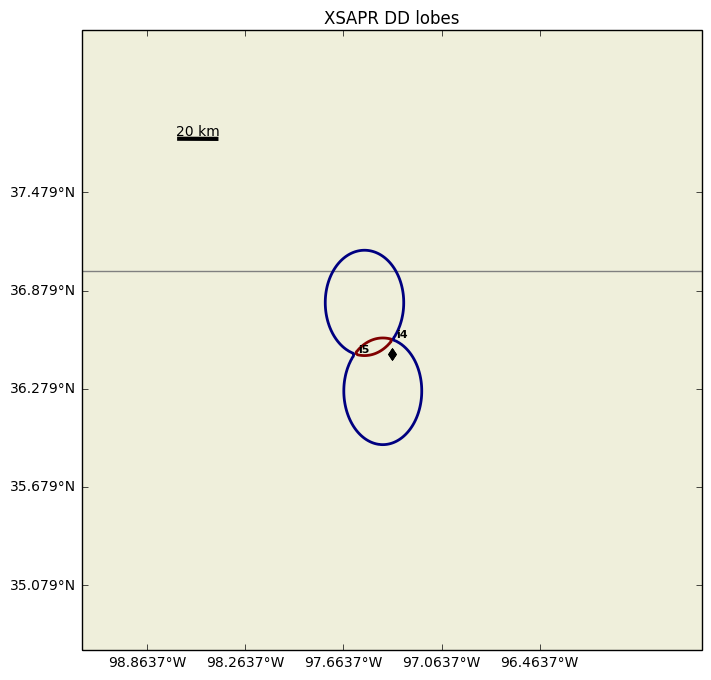

In [36]:
# Amf locations
i5 = [dms_to_decimal(-97, 35, 37.68), dms_to_decimal(36, 29, 29.4)]
i4 = [dms_to_decimal(-97, 21, 49.32), dms_to_decimal(36, 34, 44.4)]


plt.figure(figsize=(8,10))
plot_dd_lobes(i4, i5, 'i4', 'i5')
plt.title('XSAPR DD lobes')